In [408]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.preprocessing import image
import time
import pickle
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import *

In [1]:
# Reading Caption wali file

with open("./flicker8k-dataset/Flickr8k_text/Flickr8k.token.txt") as f:
    captions = f.read()

In [4]:
print(captions[:1000])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .
1002674143_1b742ab4b8.jpg#0	A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
1002674143_1b

In [12]:
captions = captions.split("\n")[:-1]

In [31]:
# dict key : 'img_name' , value  : list of all captions
descriptions = {}

for ele in captions:
    i_to_c = ele.split('\t')
    img_name = i_to_c[0].split(".")[0]
    cap = i_to_c[1]
    
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
        
    descriptions[img_name].append(cap)

In [33]:
len(descriptions)

8092

In [34]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

## Data Cleaning

In [49]:
"""
1. lower case
2. remove punctuations
3. remove words length less than 2
"""
import re

def clean_text(sample):
    sample = sample.lower()
    
    sample = re.sub("[^a-z]+", " ", sample)
    
    sample = sample.split()
    
    sample = [s for s in sample if len(s)>1] # list comprehension
    
    sample = " ".join(sample)
    return sample

In [50]:
clean_text("My hobby is cricket, father's I play badmintion....#### 1234 dog walking..!")

'my hobby is cricket father play badmintion dog walking'

In [55]:
# modifiying all captions - cleaned captions

for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc_list[i] = clean_text(desc_list[i])

In [56]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [60]:
f = open('descriptions.txt', 'w')
f.write(str(descriptions))
f.close()

In [66]:
# finding unique vocabulary

vocabulary = set()

for key in descriptions.keys():
    [ vocabulary.update(i.split()) for i in descriptions[key]]
    

In [69]:
print("vocabulary size : " , len(vocabulary))

vocabulary size :  8424


In [73]:
# All words in description dictionary
all_vocab = []

for key in descriptions.keys():
    [ all_vocab.append(i) for des in descriptions[key] for i in des.split()]

In [77]:
print("total words appearing : " , len(all_vocab))

total words appearing :  373837


In [82]:
from collections import Counter

counter = Counter(all_vocab)

In [86]:
dic_ = dict(counter)

In [91]:
sorted_dic = sorted(dic_.items(), key = lambda x: x[1], reverse=True)

In [103]:
threshold_value = 10

d = [x for x in sorted_dic if x[1]>threshold_value]

In [104]:
len(d)

1845

In [106]:
all_vocab = [x[0] for x in d]

In [107]:
len(all_vocab)

1845

# Load Training and Testing Data

In [109]:
# Read Train File

with open('flicker8k-dataset/Flickr8k_text/Flickr_8k.trainImages.txt') as f:
    train = f.read()

In [127]:
train = [e[:-4] for e in train.split('\n')[:-1]]    

In [129]:
# Read test File

with open('flicker8k-dataset/Flickr8k_text/Flickr_8k.testImages.txt') as f:
    test = f.read()

In [130]:
test = [e[:-4] for e in test.split('\n')[:-1]]    

In [140]:
train_descriptions = {}

for t in train:
    train_descriptions[t] = []
    for cap in descriptions[t]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[t].append(cap_to_append)

In [141]:
len(train_descriptions)

6000

# Data Preprocessing - Images

In [154]:
from keras.applications.resnet50 import ResNet50, preprocess_input

In [145]:
model = ResNet50(weights = 'imagenet', input_shape = (224,224,3))

In [146]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [152]:
model_new = Model(inputs = model.input, outputs =  model.layers[-2].output)

In [182]:
def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis = 0)

    return img

In [183]:
def encode_image(img):
    img = preprocess_image(img)
    fea_vec = model_new.predict(img)
    fea_vec = fea_vec.reshape(fea_vec.shape[1], )
    return fea_vec

In [187]:
images = "./flicker8k-dataset/Flickr8k_Dataset/"

In [201]:
start = time.time()

encoding_train = {}

for ix, img in enumerate(train):
    
    img = images+train[ix]+".jpg"
    
    p = encode_image(img)
    
    encoding_train[ img[len(images):] ] = p
    
    
    if ix%100 == 0:
        print("Encoding image :" + str(ix))
    
print("Time taken in sec - " + time.time() - start)

Encoding image :0
Encoding image :100
Encoding image :200
Encoding image :300
Encoding image :400
Encoding image :500


KeyboardInterrupt: 

In [ ]:
start = time.time()

encoding_test = {}

for ix, img in enumerate(test):
    
    img = images+test[ix]+".jpg"
    
    p = encode_image(img)
    
    encoding_test[ img[len(images):] ] = p
    
    
    if ix%100 == 0:
        print("Encoding image :" + str(ix))
    
print("Time taken in sec - " + time.time() - start)

In [205]:
# saving features to disk

with open("./encoded_train_images.pkl", 'wb') as f:
    pickle.dump(encoding_train, f )

In [208]:
# loading features from disk

with open("./encoded_train_images.pkl", 'rb') as f:
    encoding_train = pickle.load(f)

    
with open("./encoded_test_images.pkl", 'rb') as f:
    encoding_test = pickle.load(f)

In [209]:
len(encoding_train)

6000

In [210]:
len(encoding_test)

1000

# Data Preprocessing - Captions

In [215]:
word_to_idx = {}
idx_to_word = {}

ix = 1

for e in all_vocab:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    
    ix +=1

In [224]:
word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

In [226]:
vocab_size = len(idx_to_word) + 1
print(vocab_size)

1848


In [231]:
all_caption_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_caption_len.append(len(cap.split()))

In [233]:
max_len = max(all_caption_len)
print(max_len)

35


# Generator Function

In [299]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len,  num_photos_per_batch ):
    X1, X2, y = [], [], []
    
    n=0
    
    while True:
        
        for key, desc_list in train_descriptions.items():
            n+=1
            
            photo = encoding_train[key+'.jpg']
            
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                
                
                for i in range(1, len(seq)):
                    in_seq = seq[0:i]
                    out_seq = seq[i]
                    
                    in_seq = pad_sequences( [in_seq], maxlen=max_len, value= 0, padding='post')[0]
                
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
                    
            if n == num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)] , np.array(y) ]
                X1, X2, y = [], [], []
                n =0

In [308]:
for i in data_generator(train_descriptions, encoding_train, word_to_idx, max_len, 3):
    X, y = i
    print(X[0].shape)
    print(X[1].shape)
    print(y.shape)
    break

(147, 2048)
(147, 35)
(147, 1848)


# Word Embedding

In [309]:
embeddings = {}

with open('./GloVE/glove.6B.50d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.array(values[1:], dtype="float32")
        
        embeddings[word] = coeffs

In [332]:
def getOutputEmbeddings():

    emb_dim = 50
    embedding_matrix_output = np.zeros((vocab_size, emb_dim ))
    
    for word, idx in word_to_idx.items():
        
        emb_vec = embeddings.get(word)
        
        if emb_vec is not None:
            embedding_matrix_output[idx] = emb_vec
            
    return embedding_matrix_output

In [333]:
embedding_output = getOutputEmbeddings()

In [349]:
embedding_output.shape

(1848, 50)

# Model Architecture

In [351]:
#  image feature extractor model

input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [352]:
# partial caption sequence model

input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim= vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [353]:
decoder1 = add([inp_img2, inp_cap3])

decoder2 = Dense(256, activation='relu')(decoder1)
output = Dense(vocab_size, activation='softmax')(decoder2)


model = Model(inputs = [input_img_fea, input_cap]  , outputs =  output )

In [354]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [369]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [371]:
model.compile(loss="categorical_crossentropy", optimizer='adam')

# Train Model

In [373]:
epochs = 10
number_photos_per_batch = 3
steps = len(train_descriptions)//number_photos_per_batch

In [375]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_photos_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save("best_model.h5")

Epoch 1/1
  78/2000 [>.............................] - ETA: 12:39 - loss: 5.7155

KeyboardInterrupt: 

In [377]:
model = load_model("model_weights/model_9.h5")

In [378]:
model

# Predictions

In [431]:
def predict(photo_enc):
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[word] for word in in_text.split() if word in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')
        
        y_pred = model.predict([photo_enc, sequence])
        y_pred = np.argmax(y_pred)
        word = idx_to_word[y_pred]
        
        in_text += " "+word
        
        if word == 'endseq':
            break
        
        
    final_caption = in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = " ".join(final_caption)
    return final_caption

man in black shirt is walking through the water


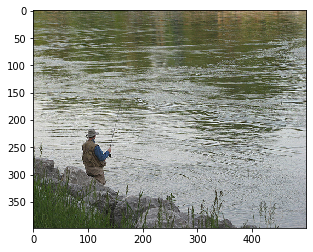

In [440]:
rn = np.random.randint(0,1000)
img_id = list(encoding_test.keys())[rn]

photo_enc = encoding_test[img_id].reshape((1,2048))
pred = predict(photo_enc)
print(pred)

path = images + img_id
img = plt.imread(path)
plt.imshow(img)
plt.show()